# Stochastic Processes
A collection of random variables indexed by time or space. Each variable represents the state of a system at a certain index (e.g., time), and the process describes how these states evolve probabilistically.
# Gaussian Processes
A type of stochastic process where any finite set of variables follows a multivariate normal (Gaussian) distribution. A GP is fully defined by a mean function and a covariance (kernel) function. GPs are commonly used for non-parametric Bayesian modeling, especially in regression tasks, where they offer uncertainty quantification.
# Variational Inference
An optimization-based method for approximating complex posterior distributions in Bayesian inference. It involves selecting a simpler family of distributions and finding the closest member (in terms of KL divergence) to the true posterior.

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Sampling: [f_pred]


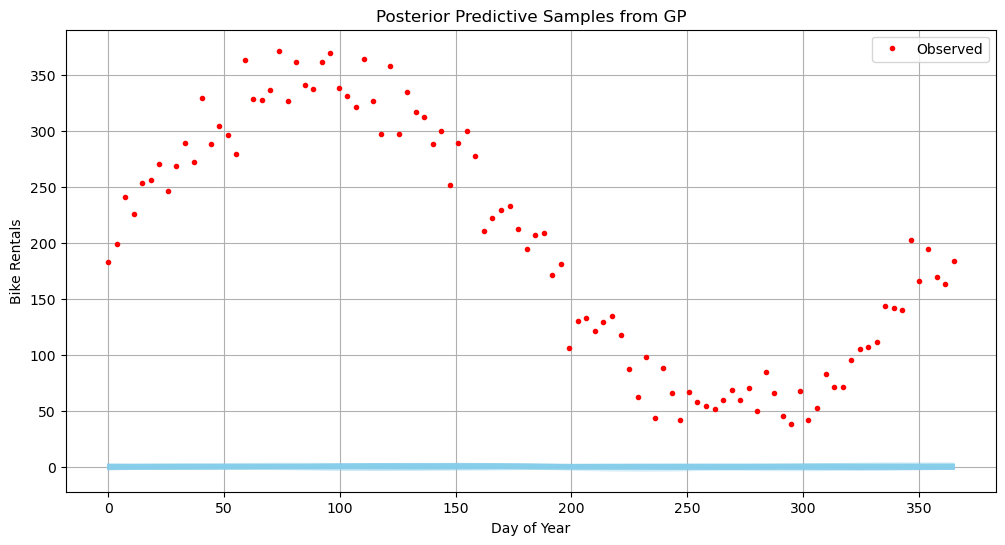

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# Reuse your X, Y (bike rental data)
X = np.linspace(0, 365, 100)[:, None]
true_trend = 200 + 150 * np.sin(2 * np.pi * X.flatten() / 365)
Y = true_trend + np.random.normal(0, 20, size=100)

# GP model
with pm.Model() as model:
    mean_func = pm.gp.mean.Zero()
    cov_func = pm.gp.cov.ExpQuad(1, ls=50.0)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    sigma = pm.HalfNormal("sigma", 10.0)
    y_ = gp.marginal_likelihood("y", X=X, y=Y, noise=sigma)
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.9)

# New inputs for prediction (365 full days)
X_new = np.linspace(0, 365, 200)[:, None]

# Predictive posterior sampling
with model:
    # Step 1: define predictive conditional
    f_pred = gp.conditional("f_pred", X_new)

    # Step 2: draw samples from the posterior predictive
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], random_seed=42)

# Now this works:
plt.figure(figsize=(12, 6))

# Plot 100 posterior predictive samples
for i in range(100):
    plt.plot(X_new.flatten(), pred_samples.posterior_predictive["f_pred"].isel(chain=0, draw=i), 
             color="skyblue", alpha=0.3)

# Observed points as red dots
plt.plot(X.flatten(), Y, "r.", label="Observed")

plt.xlabel("Day of Year")
plt.ylabel("Bike Rentals")
plt.title("Posterior Predictive Samples from GP")
plt.legend()
plt.grid(True)
plt.show()


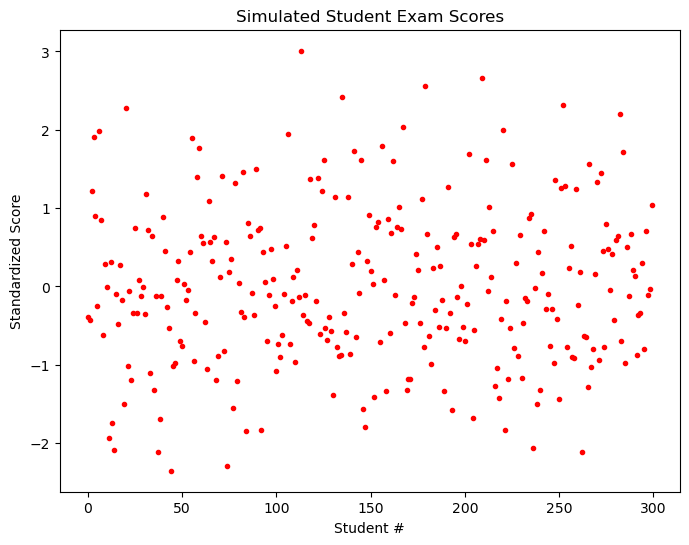

Finished [100%]: Average Loss = 446.54


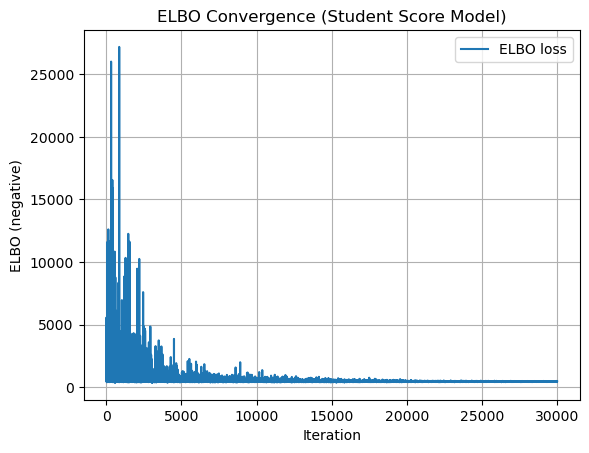

In [13]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# ----------- REPLACED DATA: Student Exam Scores ----------- #
np.random.seed(42)
N = 300

# Inputs: study hours, attendance rate, assignments done
study_hours = np.random.normal(5, 2, N)
attendance = np.random.uniform(0.5, 1.0, N)
assignments_done = np.random.randint(5, 10, N)

X = np.column_stack([study_hours, attendance, assignments_done])

# Target: Exam score (standardized)
y_true = 20 + 10*study_hours + 30*attendance + 5*assignments_done + np.random.normal(0, 10, N)
y = (y_true - y_true.mean()) / y_true.std()
# ----------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(y, "r.")
ax.set(title="Simulated Student Exam Scores", xlabel="Student #", ylabel="Standardized Score")
plt.show()

# ----------- PyMC Neural Network Model (Unchanged) ----------- #
with pm.Model() as neural_network:
    # Priors for hidden layer
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(3, 5))
    biases_1 = pm.Normal("b1", 0, sigma=1, shape=(5,))

    # Hidden layer computation
    acts_1 = pm.math.tanh(pm.math.dot(X, weights_in_1) + biases_1)

    # Output layer
    weights_2 = pm.Normal("w_2", 0, sigma=1, shape=(5,))
    bias_out = pm.Normal("b_out", 0, sigma=1)

    # Final output
    acts_out = pm.math.dot(acts_1, weights_2) + bias_out

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=acts_out, sigma=sigma, observed=y)

# ----------- Variational Inference (ADVI) ----------- #
with neural_network:
    approx = pm.fit(n=30000, method="advi")
    trace = approx.sample(1000)
# ---------------------------------------------------- #

# Plot ELBO convergence
plt.plot(approx.hist, label="ELBO loss")
plt.xlabel("Iteration")
plt.ylabel("ELBO (negative)")
plt.title("ELBO Convergence (Student Score Model)")
plt.legend()
plt.grid(True)
plt.show()

